## Image contrast

In [2]:
import numpy as np
from skimage import io, exposure, measure, morphology
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian, median
import pandas as pd
from stardist.models import StarDist2D 
import time
import scipy
rng = np.random.default_rng(2021)

2022-03-08 10:30:58.933376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 10:30:58.933392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# prints a list of available models 
StarDist2D.from_pretrained() 

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2022-03-08 10:30:59.734777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 10:30:59.734797: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 10:30:59.734809: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (solveig-ThinkPad-X1-Carbon-Gen-9): /proc/driver/nvidia/version does not exist
2022-03-08 10:30:59.734924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plotting function with optional zoom area:

In [4]:
def plot_pred_overlay(img, labels, zoom=False):
    '''Plots image and predicted labels

    :param img: 2D image
    :type img: ndarray
    :param labels: color-labels of pixels in img
    :type labels: ndarray
    :param zoom: [x1, y1, x2, y2], area of img where you want to zoom in
    :rtype zoom: list, opt

    '''

    if zoom:
        x1, y1, x2, y2 = zoom
    else:
        x1, y1 = [0, 0]
        x2, y2 = img.shape

        
    num_cells = len(measure.regionprops(labels))
    
    fig = plt.figure(figsize=(24, 24))

    plt.subplot(2,2,1)

    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("input image")

    plt.subplot(2,2,2)
    plt.imshow(render_label(labels, img=img))
    plt.axis("off")
    plt.title(str(num_cells) + 'predicted cells')
    
    
    plt.subplot(2, 2, 3)
    plt.imshow(img[x1:x2, y1:y2], cmap='gray')
    plt.axis("off")
    plt.title("input image, zoomed")

    plt.subplot(2, 2, 4)
    plt.imshow(render_label(labels[x1:x2, y1:y2], img=img[x1:x2, y1:y2]))
    plt.axis("off")
    plt.title("prediction + input overlay")

    plt.savefig('')
    plt.show()
    return fig

#### Load image

In [8]:
img = io.imread('../data/raw/0104_p301s_nissl.jpg') 
img_gray = rgb2gray(img)
labels, details = model.predict_instances(normalize(img_gray))

#### Check out the intensity distribution:

Take out too small objects

In [9]:
max_diams = [lab.feret_diameter_max for lab in measure.regionprops(labels)]
np.min(max_diams)
sum([diam < 10 for diam in max_diams])

118

After doing some checking in ImageJ, it seems like cells with a diameter of 20pixels is roughly where we want to set the cutoff.
Since the roundness is an important feature of the cell, we use a small area as a cutoff and not a small "max length". 

In [10]:
min_area = np.round(np.pi*10**2)
min_area

314.0

Conveniently, skimage has a very nice method for removing small objects:
> skimage.morphology.remove_small_objects

(2048, 2048)
(2048, 2048)


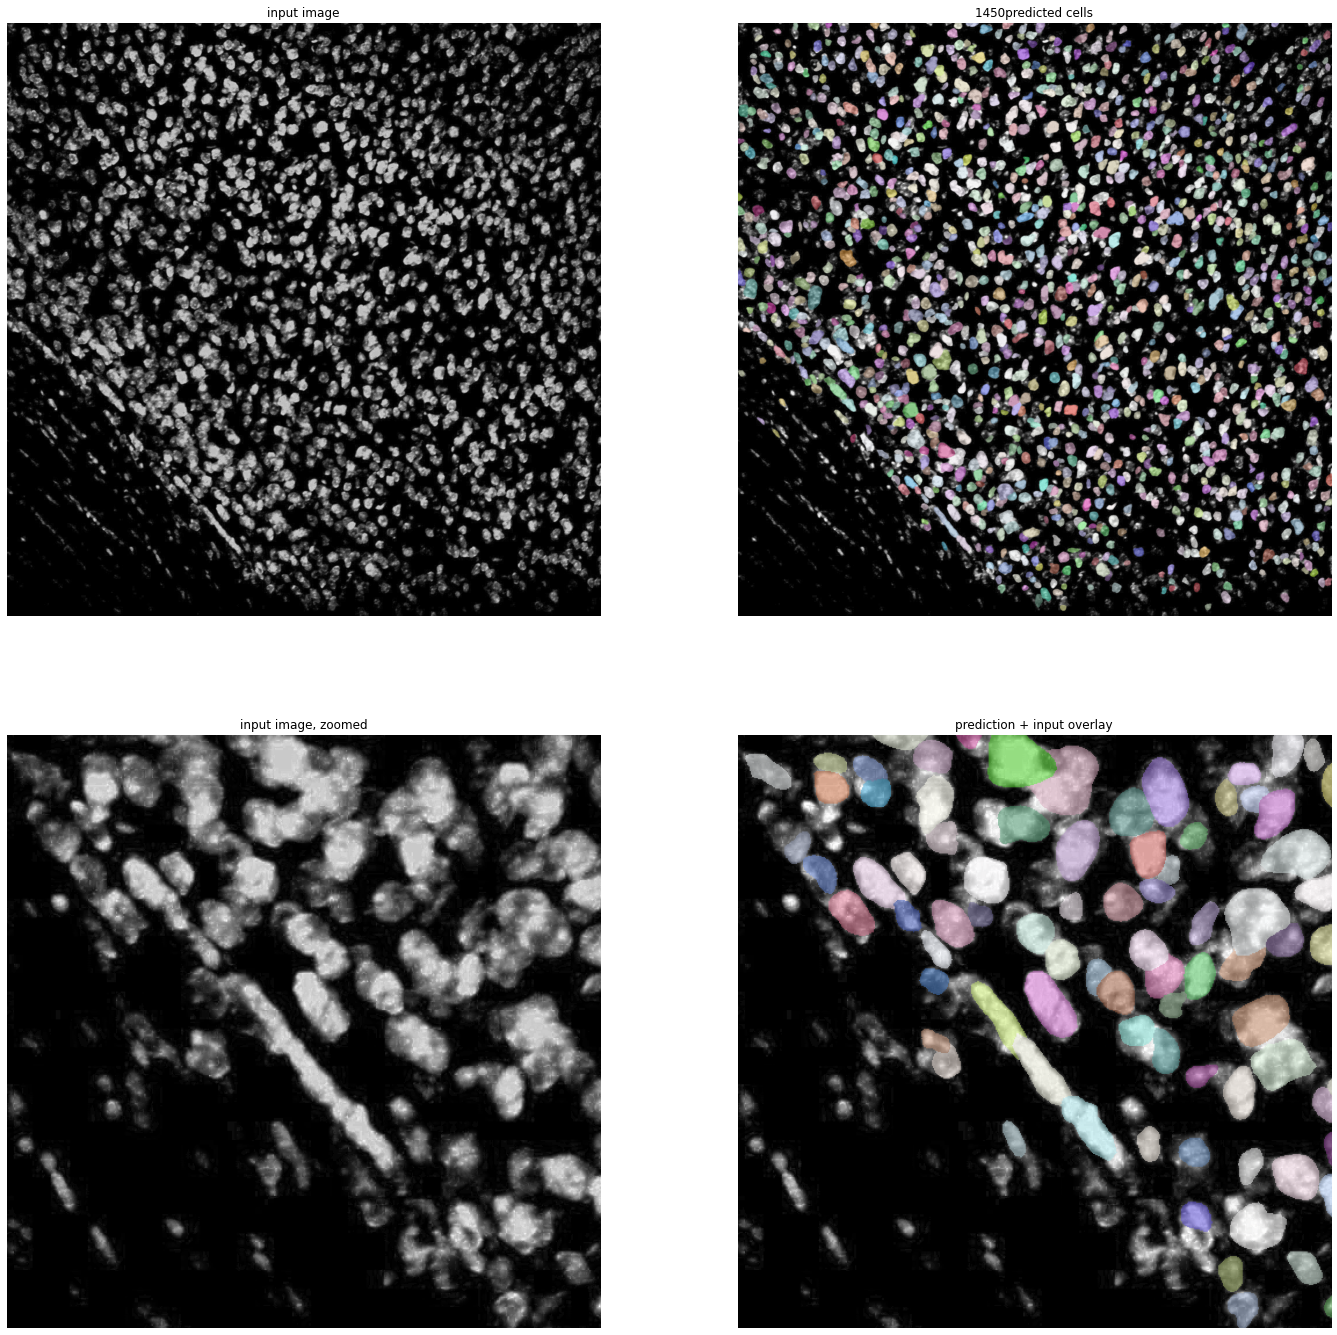

In [11]:
labels, details = model.predict_instances(normalize(img_gray))
labels_no_small = morphology.remove_small_objects(labels, min_size=min_area)
print(labels_no_small.shape)
print(labels.shape)
zoom_area = [1458,474,1970, 986]
fig = plot_pred_overlay(img_gray, labels_no_small, zoom=zoom_area)

### Very long cells are not cells

Need to filter out too long objects, as these are some other fibers (white matter)

According to Elise, a cell with these properties is a cell:
a = 64
b = 32

This means that we can test this simple rule:

```
if a/ b > 2:
    remove cell
```

In measure.regprops, we can find a lot of different properties, also the length of the a- and b-axes:

In [12]:
t_start = time.time()
reg_props = measure.regionprops(labels)
a_s = np.array([lab_props.axis_major_length for lab_props in reg_props])
b_s = np.array([lab_props.axis_minor_length for lab_props in reg_props])
r_s = a_s/b_s
r_s.shape

(2789,)

In [13]:
def remove_long_cells(segments, max_ab_ratio):
    out = segments.copy()

    reg_props = measure.regionprops(segments)
    a_s = np.array([lab_props.axis_major_length for lab_props in reg_props])
    b_s = np.array([lab_props.axis_minor_length for lab_props in reg_props])
    r_s_ = a_s/b_s
    
    r_s = np.zeros(r_s_.shape[0] + 1)
    r_s[1:] = r_s_
    
    too_long = r_s > max_ab_ratio
    too_long_mask = too_long[out]
    out[too_long_mask] = 0

    return out

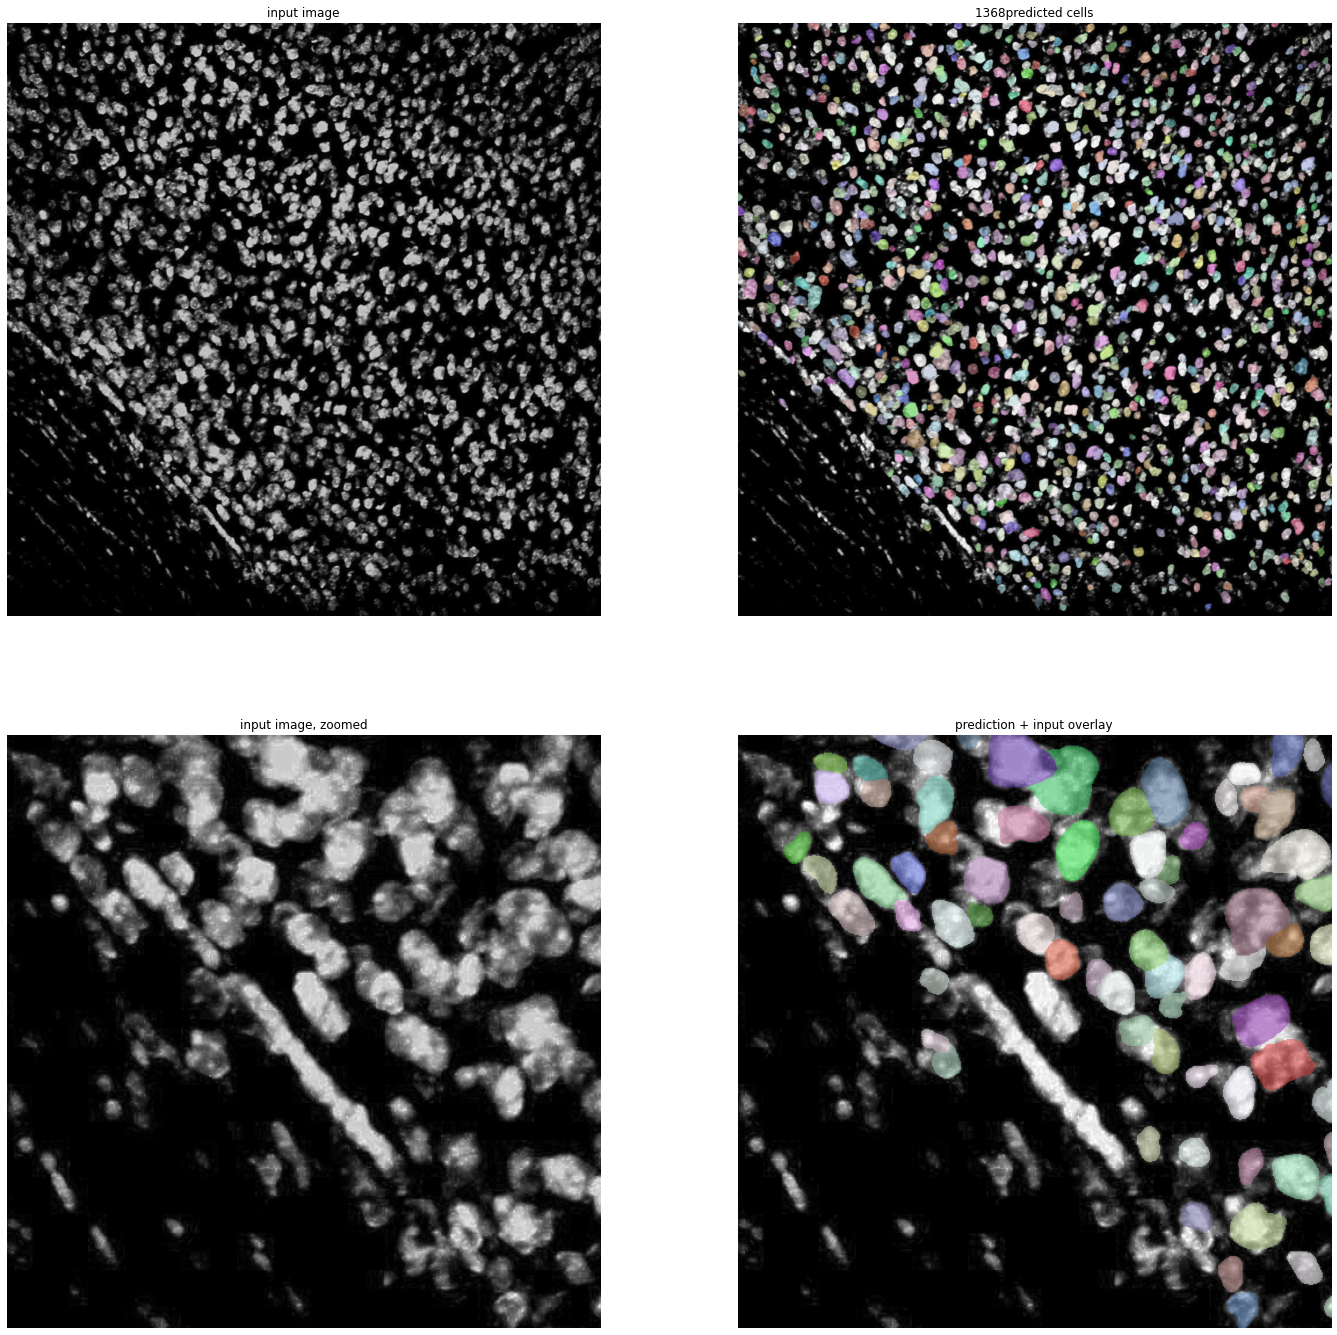

In [15]:
labels_no_long = remove_long_cells(labels, 2)
labels_no_small_or_long = morphology.remove_small_objects(labels_no_long, 
                                                           min_size=min_area)
zoom_area = [1458,474,1970, 986]
fig = plot_pred_overlay(img_gray, labels_no_small_or_long, zoom=zoom_area)

This looks good!  
But: If we switch the order of remove_long and remove_small, så funker det ikke!  
  
Har ikke helt forstått hvordan

```too_long[ccs] ```  
fungerer. Det kan være her det ligger. Se nedenfor.  

Men først: Lage funksjon for å telle celler:

In [17]:
num_cells = labels.max()
num_cells

2789

Siden bakgrunnen har label=0, vil høyeste label index referere til antall celler.
Kan det være at det blir problemer når vi fjerner celler?

In [18]:
labels_no_small.max()

2787

Ja, dette så ikke så bra ut. Tror det er minst 100 små celler.  
Her går det sikkert an å relable etter fjerning. Men tror kanskje dette er litt bortkastet tid? Kanskje bedre å gjøre det sånn, selvom ```.measure``` virker litt treig?

In [22]:
num_cells2 = len(measure.regionprops(labels_no_small))
num_cells2

1450

In [ ]:
print('labels:', labels.shape, type(labels))
print('labels_no_small', labels_no_small.shape, type(labels_no_small))

r_s:
[0.         1.15236835 1.10384745 ... 1.09176867 2.00901313 1.22016754]
<class 'numpy.ndarray'>
(2582,)
too_long: <class 'numpy.ndarray'> (2582,) [False False False ... False  True False]
ccs: <class 'numpy.ndarray'> (2048, 2048) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
too_long_mask: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
74624
True
4119680
4194304


[]

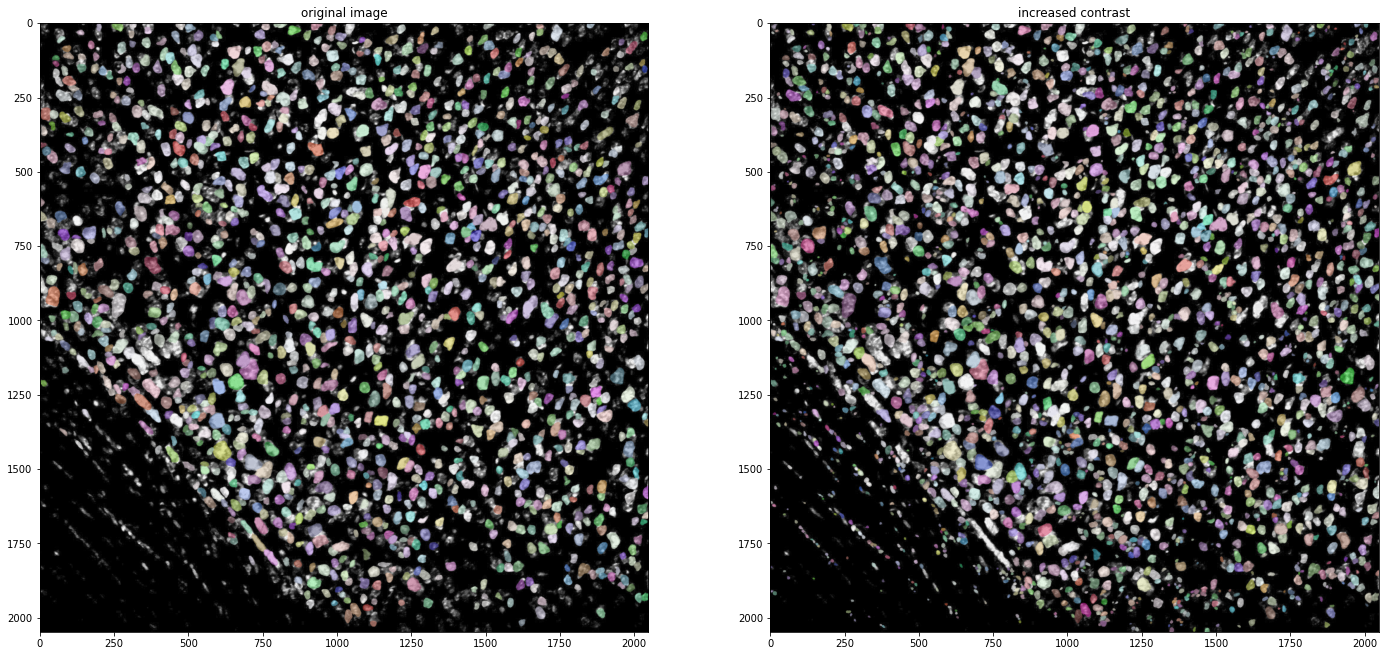

In [223]:
labs = labels
out = labs.copy()
# print('out:', type(out), out.shape)
ccs = out
# print('ccs:', type(ccs), ccs.shape)
# print('bincount before:', np.sum(ccs.ravel()))
reg_props = measure.regionprops(labs)
a_s = np.array([lab_props.axis_major_length for lab_props in reg_props])
b_s = np.array([lab_props.axis_minor_length for lab_props in reg_props])
r_s_ = a_s/b_s
r_s = np.zeros(r_s_.shape[0] + 1)

r_s[1:] = r_s_
print('r_s:')
print(r_s)
print(type(r_s))
print(r_s.shape)
too_long = r_s > 2
# too_long.reshape(too_long.shape[0])
print('too_long:', type(too_long), too_long.shape, too_long)
print('ccs:', type(ccs), ccs.shape, ccs)

too_long_mask = too_long[ccs]
print('too_long_mask:', too_long_mask)
print(np.sum(too_long_mask))
print(True in too_long_mask)
out[too_long_mask] = 0
# cells_to_remove = np.zeros_like(r_s, dtype=np.int32)
# cells_to_remove[too_long.nonzero()[0]] = 1
# print('sum of cells to remove:', np.sum(cells_to_remove))
# print('cells_to_remove')
# print(cells_to_remove)
# print(type(cells_to_remove))
# print(len(cells_to_remove))
# out[too_long] = 0
# print(out)
# print('bincount after:', np.sum(out.ravel()))

print(np.count_nonzero(labels == out))
print(2048**2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,24))
# axes = np.concatenate(axes, axis=0)
axes[0].imshow(img_gray, cmap='gray')
axes[0].imshow(render_label(labels_no_small, img=img_gray))
axes[0].set_title('original image')
axes[1].imshow(img_gray, cmap='gray')
axes[1].imshow(render_label(out, img=img_gray))
axes[1].set_title('increased contrast')
# axes[2].imshow(img_gray[1000:1200, 1000:1200], cmap='gray')
# axes[3].imshow(img_scaled[1000:1200, 1000:1200], cmap='gray')

plt.plot()

3923832
4194304


[]

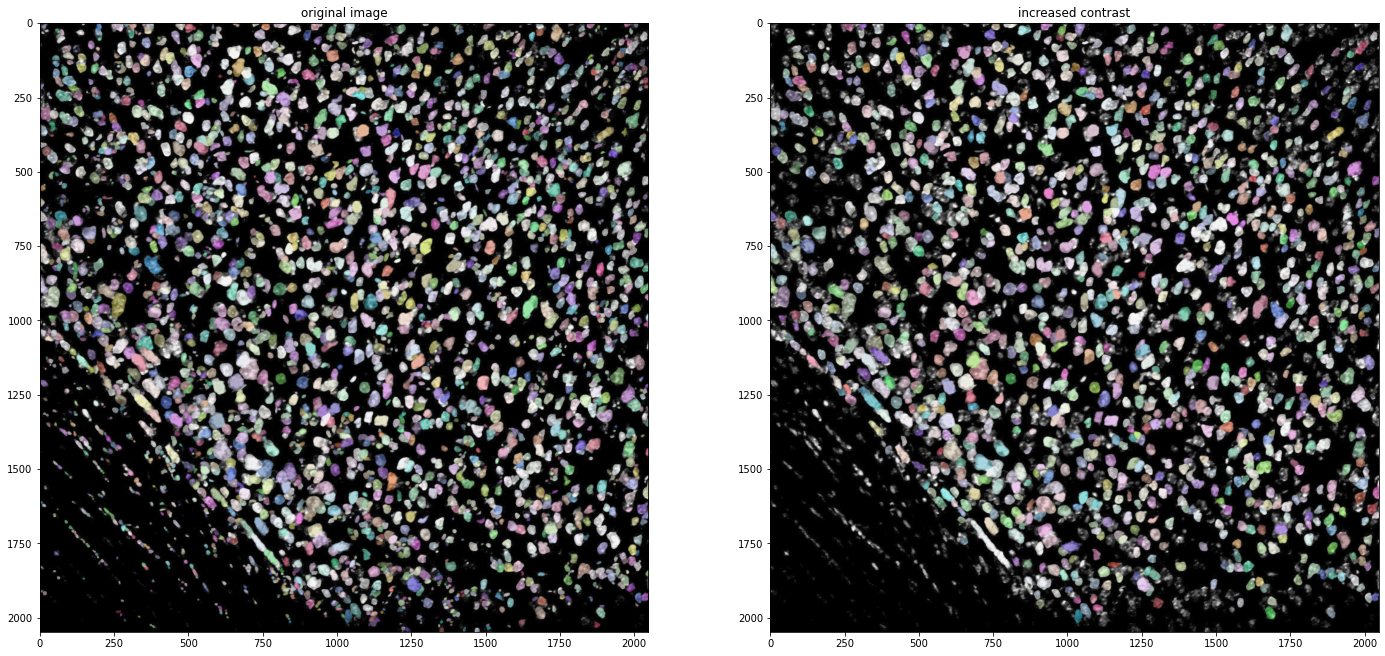

In [173]:
out = labels.copy()
ccs = out
min_size = 400
component_sizes = np.bincount(ccs.ravel())
# print('component_sizes:')
# print(component_sizes)
# print(type(component_sizes))
# print(len(component_sizes))
too_small = component_sizes < min_size
# print('too_small:')
# print(too_small)
# print(type(too_small))
# print(len(too_small))
too_small_mask = too_small[ccs]
out[too_small_mask] = 0
# print(out)
# print(np.sum(out))

print(np.count_nonzero(labels == out))
print(2048**2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,24))
# axes = np.concatenate(axes, axis=0)
axes[0].imshow(img_gray, cmap='gray')
axes[0].imshow(render_label(labels, img=img_gray))
axes[0].set_title('original image')
axes[1].imshow(img_gray, cmap='gray')
axes[1].imshow(render_label(out, img=img_gray))
axes[1].set_title('increased contrast')
axes[2].imshow(render_label(labels[1000:1200, 1000:1200], img=img_gray[1000:1200, 1000:1200]), cmap='gray')
axes[3].imshow(render_label(out[1000:1200, 1000:1200], img=img_gray[1000:1200, 1000:1200]), cmap='gray')

plt.plot()

In [97]:
too_long = r_s > 2
cells_to_remove = too_long.nonzero()[0]

out = np.copy(labels)
regions = labels.ravel()
print(regions.shape)
print(2048**2)
cells_to_remove = too_long.nonzero()[0]
too_small_mask = too_long[out]
print(cells_to_remove)
# coords_to_remove = [reg_props[cell].coords for cell in cells_to_remove]

# component_sizes = np.bincount(segments.ravel())
# too_small = component_sizes < min_size
# too_small_mask = too_small[segments]
# out[too_small_mask] = 0

(4194304,)
4194304


IndexError: index 2789 is out of bounds for axis 0 with size 2789

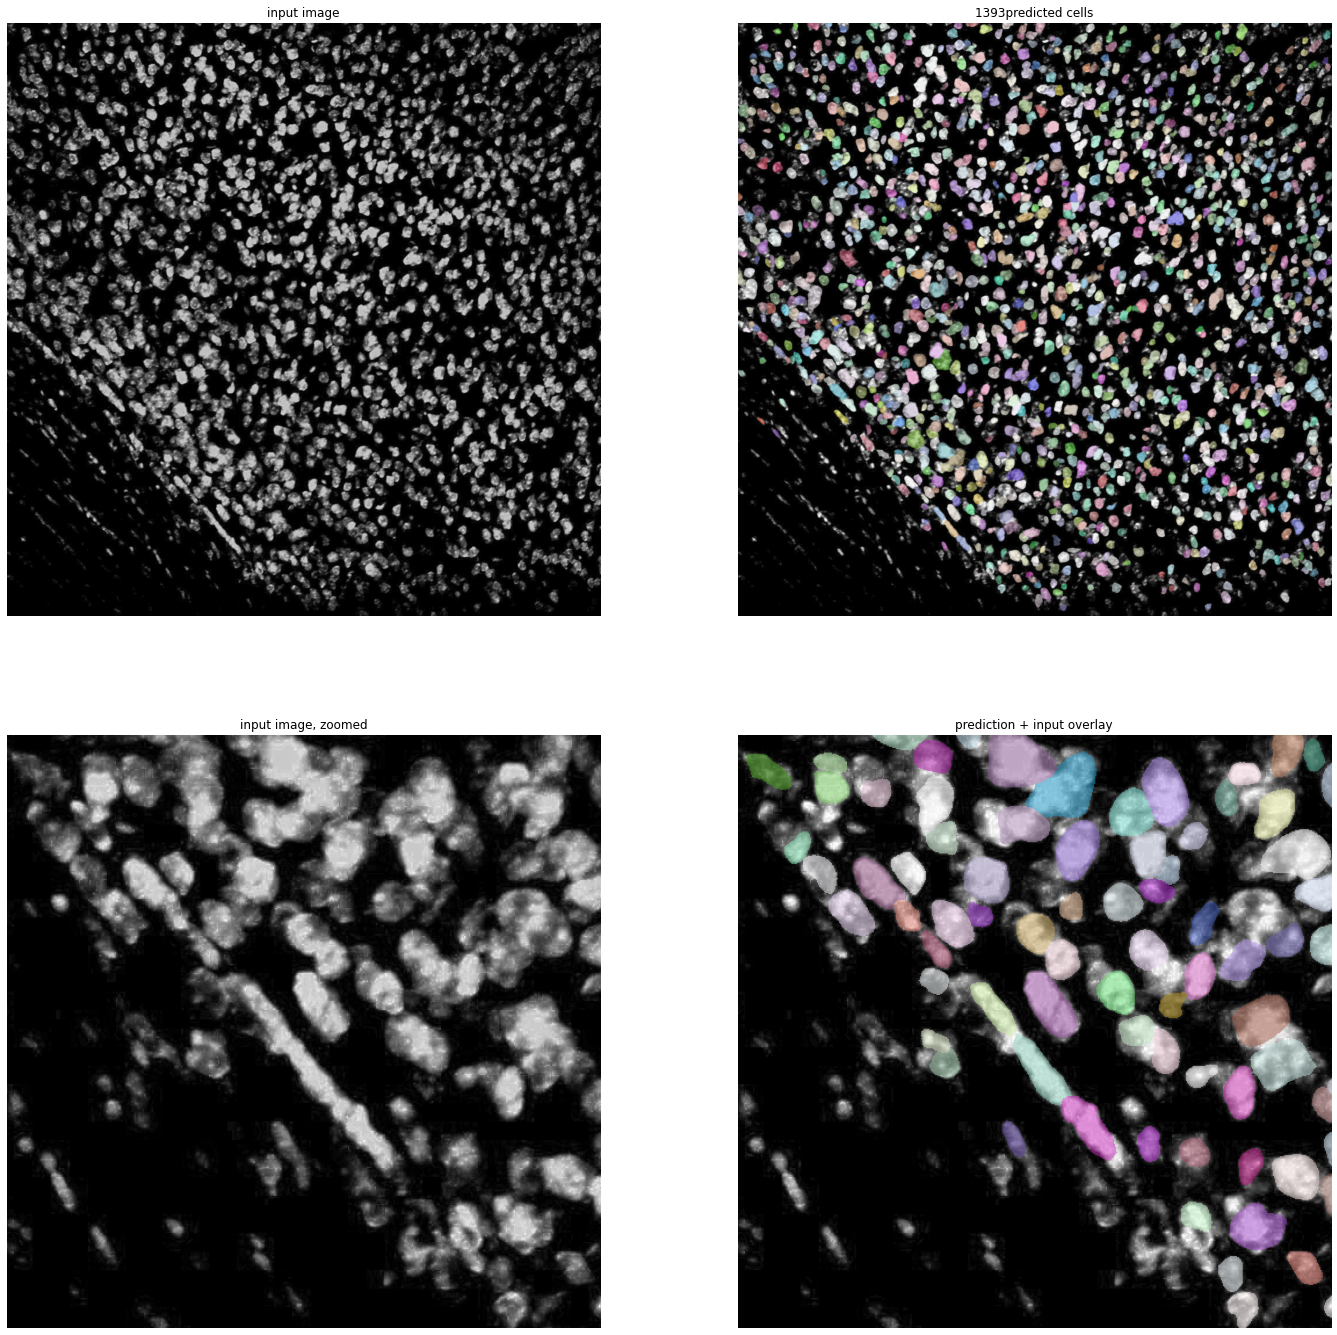

In [213]:
labels, details = model.predict_instances(normalize(img_gray), nms_thresh=0.1)
labels_no_small = morphology.remove_small_objects(labels, min_size=min_area)


zoom_area = [1458,474,1970, 986]
fig = plot_pred_overlay(img_gray, labels_no_small, zoom=zoom_area)

But: I think that the lower left should be cut out anyways.

NB: Trying to call remove_long works. But then I cannot call remove_small_objects after. What has happened?

First - need to understand what too_long[ccs] does:

In [225]:
a = np.array([[1,2,3,3],
              [4,5,6,6],
              [7,8,9,9],
              [7,8,9,9]])
ccs = np.zeros_like(a)
print('ccs:', ccs.shape, type(ccs), ccs)
cells = np.array([True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False])
print('cells:', cells.shape, type(cells), cells)
mask = cells[ccs]
print(mask)

ccs: (4, 4) <class 'numpy.ndarray'> [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
cells: (28,) <class 'numpy.ndarray'> [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


In [215]:
print('labels:', labels.shape, type(labels), labels)
print('labels_no_small', labels_no_small.shape, type(labels_no_small), labels_no_small)
print('labels_no_long', labels_no_long.shape, type(labels_no_long), labels_no_long)

labels: (2048, 2048) <class 'numpy.ndarray'> [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
labels_no_small (2048, 2048) <class 'numpy.ndarray'> [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
labels_no_long (2048, 2048) <class 'numpy.ndarray'> [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [220]:
no_long_labels = remove_long_cells(labels_no_small, 2)

IndexError: index 2245 is out of bounds for axis 0 with size 1394